In [1]:
import sys
import os
import json
import pathlib
import pickle
import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

sys.path.append(str(pathlib.Path("../src").resolve().absolute()))
from data import dataset
from models import models as mod
import model_runner

train_file = "../data/raw/topstocks_train.parquet"
valid_file = "../data/raw/topstocks_valid.parquet"
test_file = "../data/raw/topstocks_test.parquet"
supp_file = "../data/raw/topstocks_supplementary.parquet"
train_loader = DataLoader(dataset.StockData(train_file, supp_file, []), batch_size=64)
valid_loader = DataLoader(dataset.StockData(valid_file, supp_file, []), batch_size=64)
test_loader = DataLoader(dataset.StockData(test_file, supp_file, []), batch_size=64)

In [2]:
models = {}
preprocs = {}
results = {}
for config_file in pathlib.Path("../models/config").iterdir():
    config = model_runner.read_model_config(config_file)
    models[config_file.stem] = mod.load_model(config["model"], f"../models/trained/{config_file.stem}.torch")
    preprocs[config_file.stem] = config["data"]["preprocessors"]

    results_file = pathlib.Path(f"../models/trained/{config_file.stem}.torch.loss")
    if results_file.exists():
        with open(results_file, 'rb') as f:
            results[config_file.stem] = pickle.load(f)

def set_preprocs(name):
    train_loader.dataset.preprocessors = preprocs[name]
    valid_loader.dataset.preprocessors = preprocs[name]
    test_loader.dataset.preprocessors = preprocs[name]

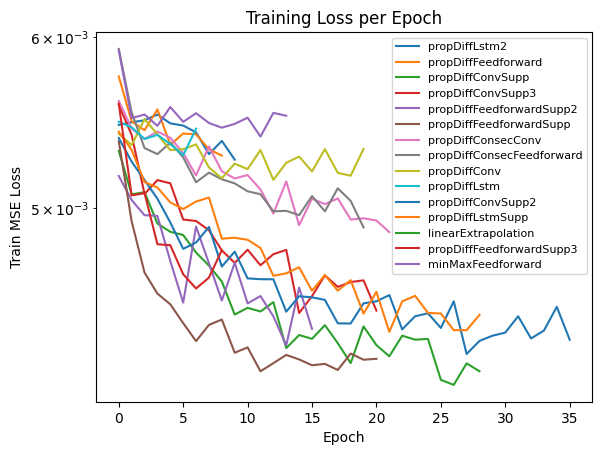

In [3]:
for model, res in results.items():
    if "train" in res:
        plt.plot(range(len(res["train"])), res["train"], label=model)
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Train MSE Loss")
plt.title("Training Loss per Epoch")
plt.legend(prop={'size': 8});

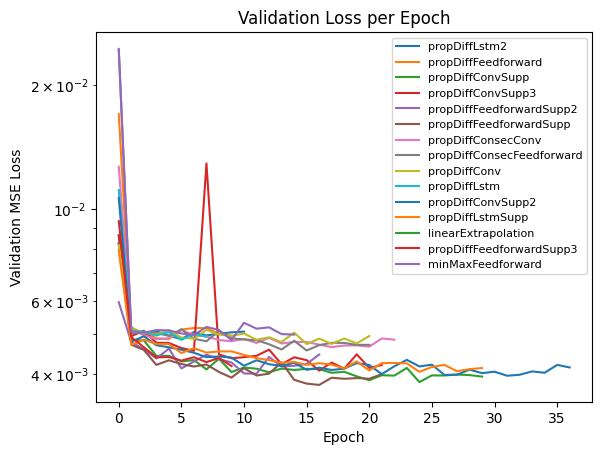

In [4]:
for model, res in results.items():
    if "train" in res:
        plt.plot(range(len(res["valid"])), res["valid"], label=model)
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Validation MSE Loss")
plt.title("Validation Loss per Epoch")
plt.legend(prop={'size': 8});

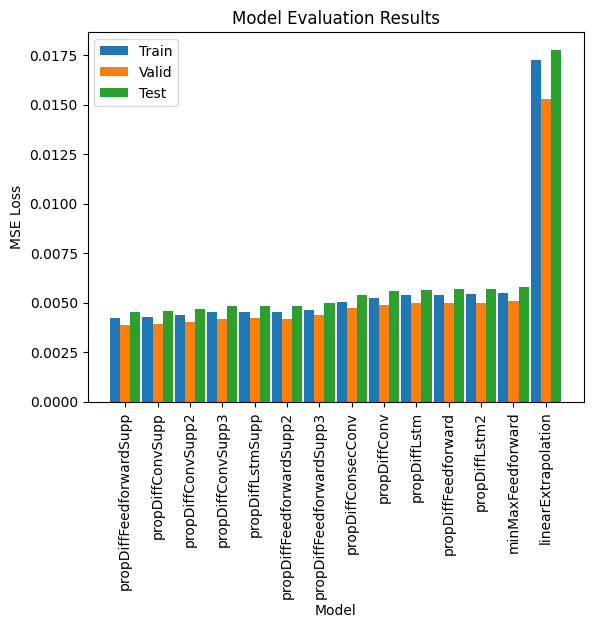

In [5]:
eval_results = pl.DataFrame({"name": [name for name, res in results.items() if "test" in res], 
                              "train": [res["test"]["train"] for _, res in results.items() if "test" in res], 
                              "valid": [res["test"]["valid"] for _, res in results.items() if "test" in res], 
                              "test": [res["test"]["test"] for _, res in results.items() if "test" in res]})

eval_results = eval_results.sort("test")
xs = np.arange(len(eval_results))

plt.bar(xs - 0.3125, eval_results["train"], 0.3125, label='Train')
plt.bar(xs, eval_results["valid"], 0.3125, label='Valid')
plt.bar(xs + 0.3125, eval_results["test"], 0.3125, label='Test')
plt.xticks(xs, eval_results["name"], rotation='vertical')
plt.xlabel("Model") 
plt.ylabel("MSE Loss")
plt.title("Model Evaluation Results") 
plt.legend();